In [2]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
!git clone https://github.com/ecesisllc/Summer2024.git

Cloning into 'Summer2024'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 18 (delta 2), pack-reused 0
Receiving objects: 100% (21/21), 2.95 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Assignment 1

In [4]:
import pandas as pd
from datetime import datetime, timedelta

def get_hours(iso, peak_type, period):
    # Define the peak hours for each ISO
    # Reference: CAISO - http://www.caiso.com/Pages/default.aspx;
    #PJM - https://www.pjm.com/about-pjm;
    #MISO - https://cce-help.misoenergy.org/knowledgebase/article/KA-01093/en-us;
    #SPP - https://www.spp.org/about-us/fast-facts/
    #NYISO - https://www.nyiso.com/documents/20142/5410485/5+OATT+1.15+-+NYC+Res+Req+Redline+v1.pdf/5073db52-9125-c49c-063b-ed1371afd407?version=1.1&download=true
    #WECC -  https://www.wecc.org/epubs/StateOfTheInterconnection/Pages/demand.aspx

    peak_hours = {
        'PJM': {'onpeak': list(range(7, 23)), 'offpeak': list(range(0, 7)) + list(range(23, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 23)), '7x8': list(range(0, 7)) + list(range(23, 24))},
        'MISO': {'onpeak': list(range(7, 22)), 'offpeak': list(range(0, 7)) + list(range(22, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 23)), '7x8': list(range(0, 7)) + list(range(23, 24))},
        'ERCOT': {'onpeak': list(range(7, 23)), 'offpeak': list(range(0, 7)) + list(range(23, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 23)), '7x8': list(range(0, 7)) + list(range(23, 24))},
        'SPP': {'onpeak': list(range(6, 22)), 'offpeak': list(range(0, 6)) + list(range(22, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(6, 22)), '7x8': list(range(0, 6)) + list(range(22, 24))},
        'NYISO': {'onpeak': list(range(7, 23)), 'offpeak': list(range(0, 7)) + list(range(23, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 23)), '7x8': list(range(0, 7)) + list(range(23, 24))},
        'WECC': {'onpeak': list(range(7, 22)), 'offpeak': list(range(0, 7)) + list(range(22, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 22)), '7x8': list(range(0, 7)) + list(range(22, 24))},
        'CAISO': {'onpeak': list(range(7, 23)), 'offpeak': list(range(0, 7)) + list(range(23, 24)), 'flat': list(range(0, 24)), '2x16H': list(range(7, 23)), '7x8': list(range(0, 7)) + list(range(23, 24))},
    }

    # Define NERC holidays (assuming 2024 for example, holidays might change every year)
    nerc_holidays = ['2024-01-01', '2024-05-27', '2024-07-04', '2024-09-02', '2024-11-28', '2024-12-25']
    nerc_holidays = [datetime.strptime(date, '%Y-%m-%d') for date in nerc_holidays]

    # Parse the period to determine the start and end dates
    if 'A' in period:
        year = int(period[:-1])
        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)
    elif 'Q' in period:
        year = int(period[:4])
        quarter = int(period[5:])
        start_month = (quarter - 1) * 3 + 1
        start_date = datetime(year, start_month, 1)
        end_month = start_month + 2
        end_date = datetime(year, end_month, pd.Period(year=year, month=end_month, freq='M').days_in_month)
    elif any(month in period for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]):
        year = int(period[:4])
        month = datetime.strptime(period[4:], '%b').month
        start_date = datetime(year, month, 1)
        end_date = datetime(year, month, pd.Period(year=year, month=month, freq='M').days_in_month)
    else:
        start_date = datetime.strptime(period, '%Y-%m-%d')
        end_date = start_date

    # Generate a date range
    date_range = pd.date_range(start_date, end_date, freq='H')

    # Determine the applicable peak hours
    hours = peak_hours[iso][peak_type]

    # Initialize total hours
    total_hours = 0

    # Iterate over the date range to count the number of peak hours
    for dt in date_range:
        if iso != 'MISO' and dt.tzinfo is None:  # if the ISO has daylight saving time
            dt = dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='shift_forward')
        if dt.hour in hours:
            if peak_type == 'onpeak' and (dt.weekday() < 5 and dt not in nerc_holidays):
                total_hours += 1
            elif peak_type == 'offpeak' and (dt.weekday() >= 5 or dt in nerc_holidays):
                total_hours += 1
            elif peak_type == '2x16H' and (dt.weekday() >= 5 or dt in nerc_holidays):
                total_hours += 1
            elif peak_type in ['flat', '7x8']:
                total_hours += 1

    return {
        'iso': iso,
        'peak_type': peak_type.upper(),
        'startdate': start_date.strftime('%Y-%m-%d'),
        'enddate': end_date.strftime('%Y-%m-%d'),
        'num_hours': total_hours
    }




In [7]:
# Sample Run
results = get_hours("ERCOT", "onpeak", "2019May")
print(results)

{'iso': 'ERCOT', 'peak_type': 'ONPEAK', 'startdate': '2019-05-01', 'enddate': '2019-05-31', 'num_hours': 352}


# Assignment 2

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
# Step 1: Load the Data
hourly_data = pd.read_csv('/content/Summer2024/data/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv')
minute_data = pd.read_csv('/content/Summer2024/data/Assignment 2 - new.app4.csv')

# Convert the time columns to datetime
#hourly_data['datetime'] = pd.to_datetime(hourly_data['Date/Time'], format='%m/%d %H:%M:%S'
hourly_data['Date/Time'] = hourly_data['Date/Time'].str.replace('24:00:00', '00:00:00')
hourly_data['datetime'] = pd.to_datetime(hourly_data['Date/Time'].str[1:], format='%m/%d %H:%M:%S').dt.strftime('%m-%d %H:%M')
minute_data['datetime'] = pd.to_datetime(minute_data['time']).dt.strftime('%m-%d %H:%M')
hourly_data = hourly_data.drop(['Date/Time'], axis=1)
minute_data = minute_data.drop(['Unnamed: 0','time'], axis=1)

In [21]:
hourly_data.set_index('datetime', inplace=True)
minute_data.set_index('datetime', inplace=True)

In [22]:
# Step 2: Resample Minute Data to Hourly
minute_data.index = pd.to_datetime(minute_data.index, format='%m-%d %H:%M')
minute_data_hourly = minute_data.resample('H').sum()/1000  # convert watts to kilowatts
minute_data_hourly.index = minute_data_hourly.index.strftime('%m-%d %H:%M')
# Step 3: Merge the DataFrames
merged_data = pd.merge(hourly_data, minute_data_hourly, left_index=True, right_index=True, how='outer')
# Filling NaNs due to outer join with 0
merged_data.fillna(0, inplace=True)
merged_data['total_hourly_consumption'] = merged_data.sum(axis=1)

In [23]:
# Displaying only merged data
merged_data[merged_data['W_min'] > 0]

,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),W_min,total_hourly_consumption
datetime,,,,,,,,,,,,,,,
06-07 11:00,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996,57.388943,60.897441
06-07 12:00,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,27.227961,31.065016
06-07 13:00,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,111.476298,115.828105
06-07 14:00,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,109.021960,113.919095
06-07 15:00,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,5.773963,11.407785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09-17 19:00,2.673612,0.034257,0.0,0.0,0.669111,0.206351,0.875462,0.206351,0.412747,0.088917,0.348977,0.497352,0.433512,0.081495,6.528146
09-17 20:00,2.802815,0.035435,0.0,0.0,0.618448,0.190689,0.809137,0.190689,0.616948,0.132907,0.316662,0.514451,0.396065,0.081474,6.705721
09-17 21:00,2.605447,0.034608,0.0,0.0,0.566775,0.173302,0.740077,0.173302,0.573501,0.123547,0.302602,0.502440,0.346635,0.082655,6.224892


## Abnormal-1

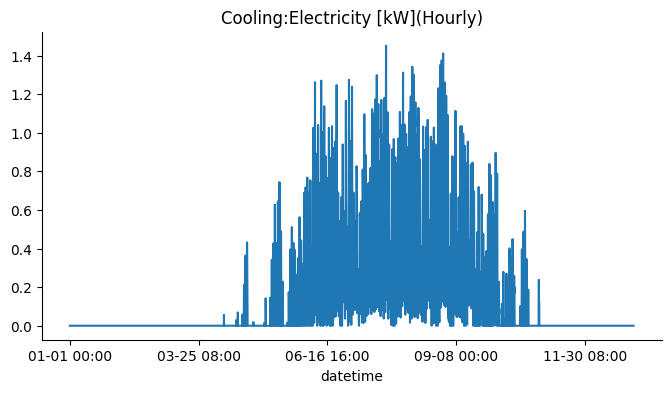

In [24]:
from matplotlib import pyplot as plt
merged_data['Cooling:Electricity [kW](Hourly)'].plot(kind='line', figsize=(8, 4), title='Cooling:Electricity [kW](Hourly)')
plt.gca().spines[['top', 'right']].set_visible(False)

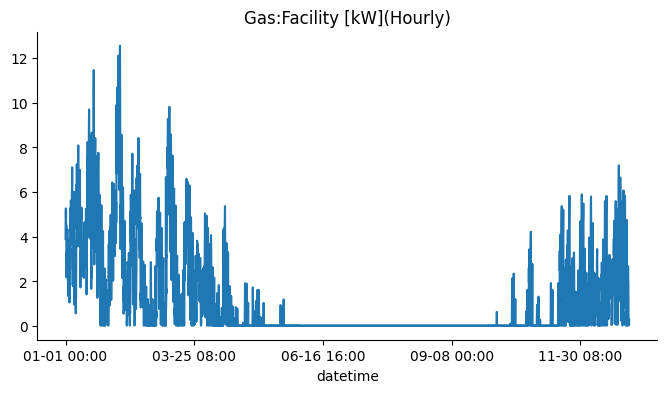

In [25]:
from matplotlib import pyplot as plt
merged_data['Gas:Facility [kW](Hourly)'].plot(kind='line', figsize=(8, 4), title='Gas:Facility [kW](Hourly)')
plt.gca().spines[['top', 'right']].set_visible(False)

The plots for gas and cooling usage correspond with each other. This means that between June and September, gas usage is very low while cooling usage is high, which aligns with our common sense.


## Abnormal - 2

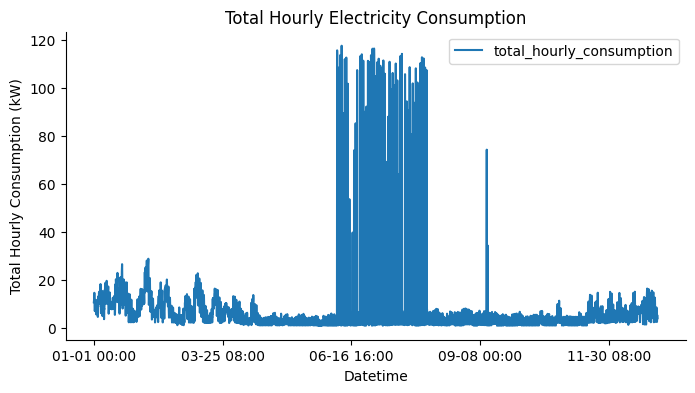

In [26]:
from matplotlib import pyplot as plt
merged_data['total_hourly_consumption'].plot(kind='line', figsize=(8, 4), title='Total Hourly Consumption')
plt.xlabel('Datetime')
plt.ylabel('Total Hourly Consumption (kW)')
plt.title('Total Hourly Electricity Consumption')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

From the plot, it's evident that the total hourly consumption sees a significant spike between June and September after merging these two datasets. This could be attributed to the usage of cooling equipment (appliance data from new.app4.csv) during the summer months. Another contributing factor might be the introduction and subsequent removal of a new instrument towards the end of the period.

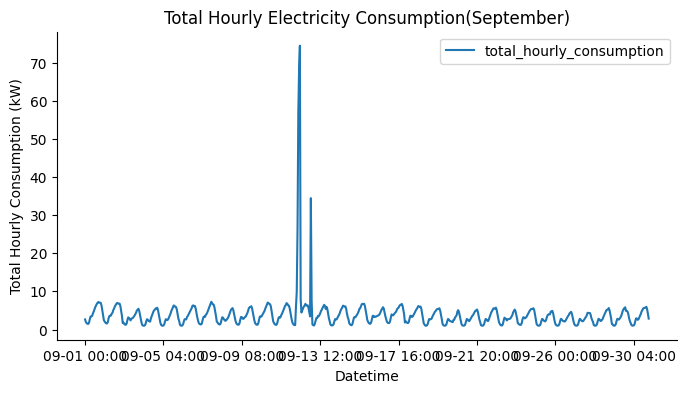

In [29]:
filtered_data = merged_data[(merged_data.index >= '09-01') & (merged_data.index < '10-01')]
filtered_data['total_hourly_consumption'].plot(kind='line', figsize=(8, 4), title='Total Hourly Consumption')
plt.xlabel('Datetime')
plt.ylabel('Total Hourly Consumption (kW)')
plt.title('Total Hourly Electricity Consumption(September)')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

From here, we observe some unusual spikes in September. These anomalies may be attributed to default data or an incident leading to a power surge.

In [ ]:
default_year = '2023'
date_strings_with_year = [f"{default_year}-{date_str}" for date_str in merged_data.index]
merged_data.index = pd.to_datetime(date_strings_with_year, format='%Y-%m-%d %H:%M')

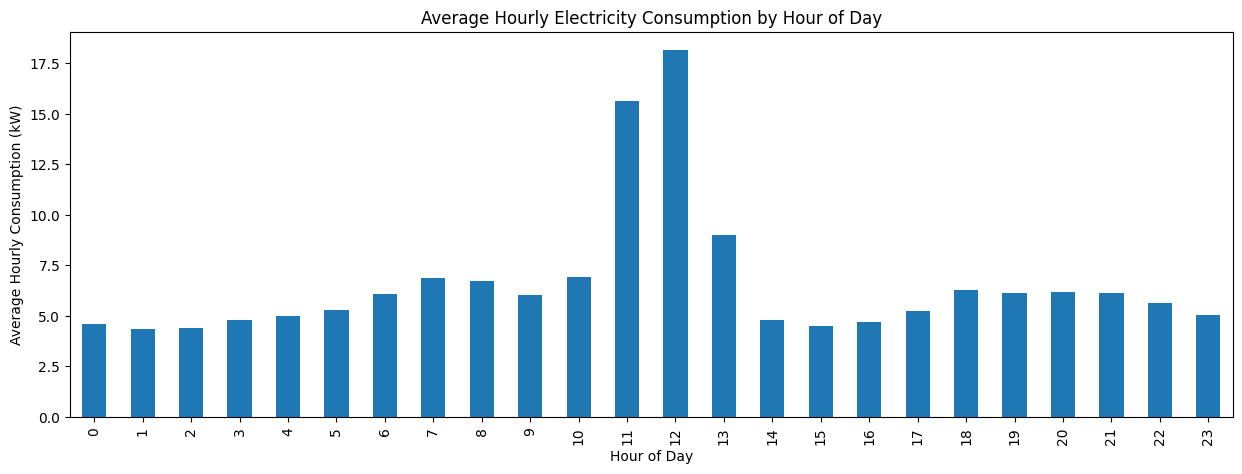

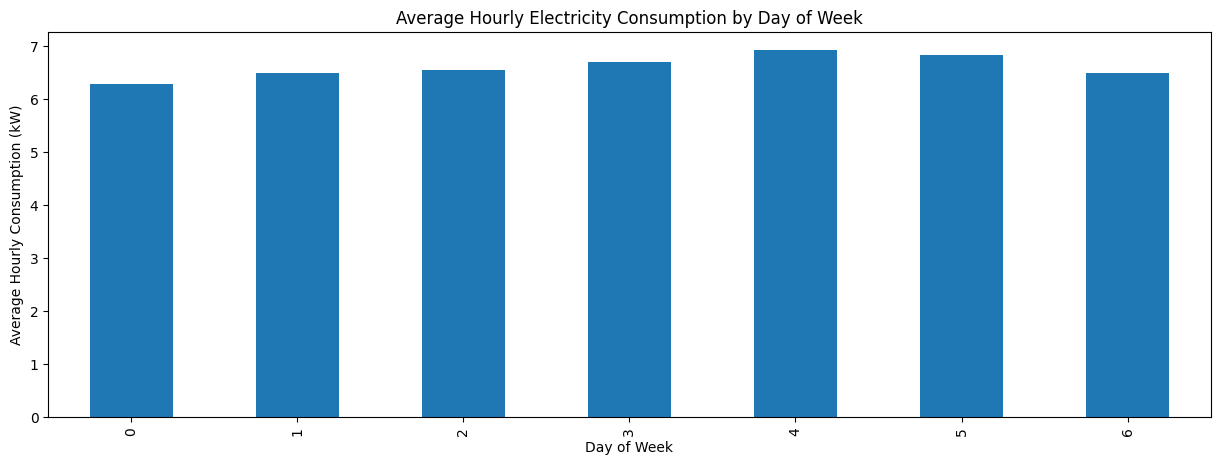

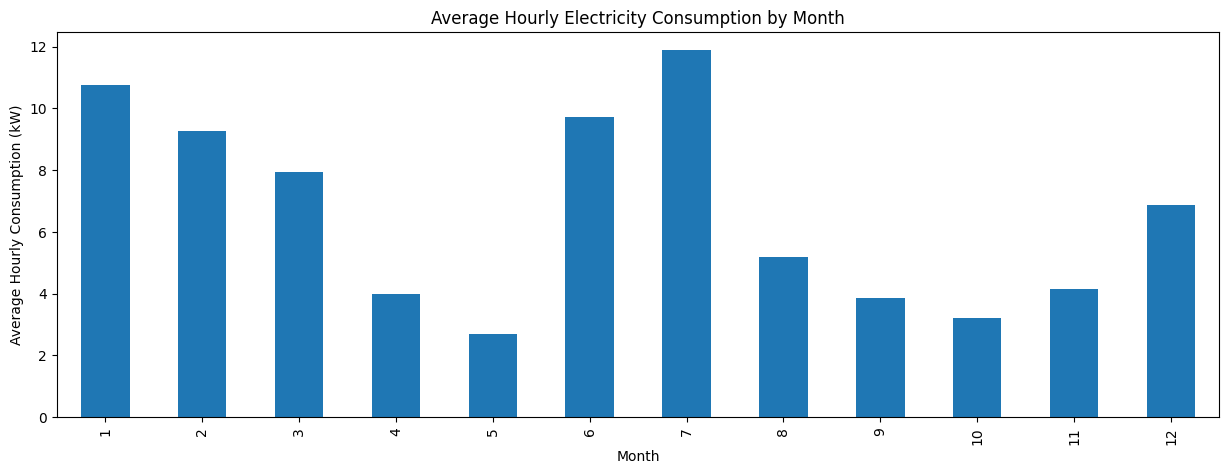

In [ ]:
# Summarize patterns by hour, weekday, and month
merged_data['hour'] = merged_data.index.hour
merged_data['weekday'] = merged_data.index.dayofweek
merged_data['month'] = merged_data.index.month

# Plot hourly patterns
plt.figure(figsize=(15, 5))
merged_data.groupby('hour')['total_hourly_consumption'].mean().plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Hourly Consumption (kW)')
plt.title('Average Hourly Electricity Consumption by Hour of Day')
plt.show()

# Plot weekday patterns
plt.figure(figsize=(15, 5))
merged_data.groupby('weekday')['total_hourly_consumption'].mean().plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Hourly Consumption (kW)')
plt.title('Average Hourly Electricity Consumption by Day of Week')
plt.show()

# Plot monthly patterns
plt.figure(figsize=(15, 5))
merged_data.groupby('month')['total_hourly_consumption'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Hourly Consumption (kW)')
plt.title('Average Hourly Electricity Consumption by Month')
plt.show()

1. **Hour of the Day**:
   - Electricity consumption is lowest during the early hours of the morning (from midnight to 6 AM) and then gradually increases.
   - A significant peak in consumption occurs between 12 PM and 1 PM, possibly due to increased activity during lunch hours.
   - There is another smaller peak around 6 PM, potentially reflecting increased household usage as people return home in the evening.
   - Consumption decreases gradually after 6 PM until it reaches its lowest levels late at night.

2. **Day of the Week**:
   - There is a relatively consistent level of electricity consumption throughout the weekdays (Monday to Friday).
  

3. **Month**:
   - Consumption decreases through February to April, likely reflecting milder weather reducing heating and cooling demands.
   - A notable spike occurs in July, possibly due to the use of air conditioning in the hot summer months.
   - Following July, there is a decrease through the cooler months of autumn (August to November).
   - There is a slight increase again in December, likely due to heating requirements and possibly increased lighting and appliance use during the holiday season.

# Assignment 3

## Exploratory Data Analysis(EDA)

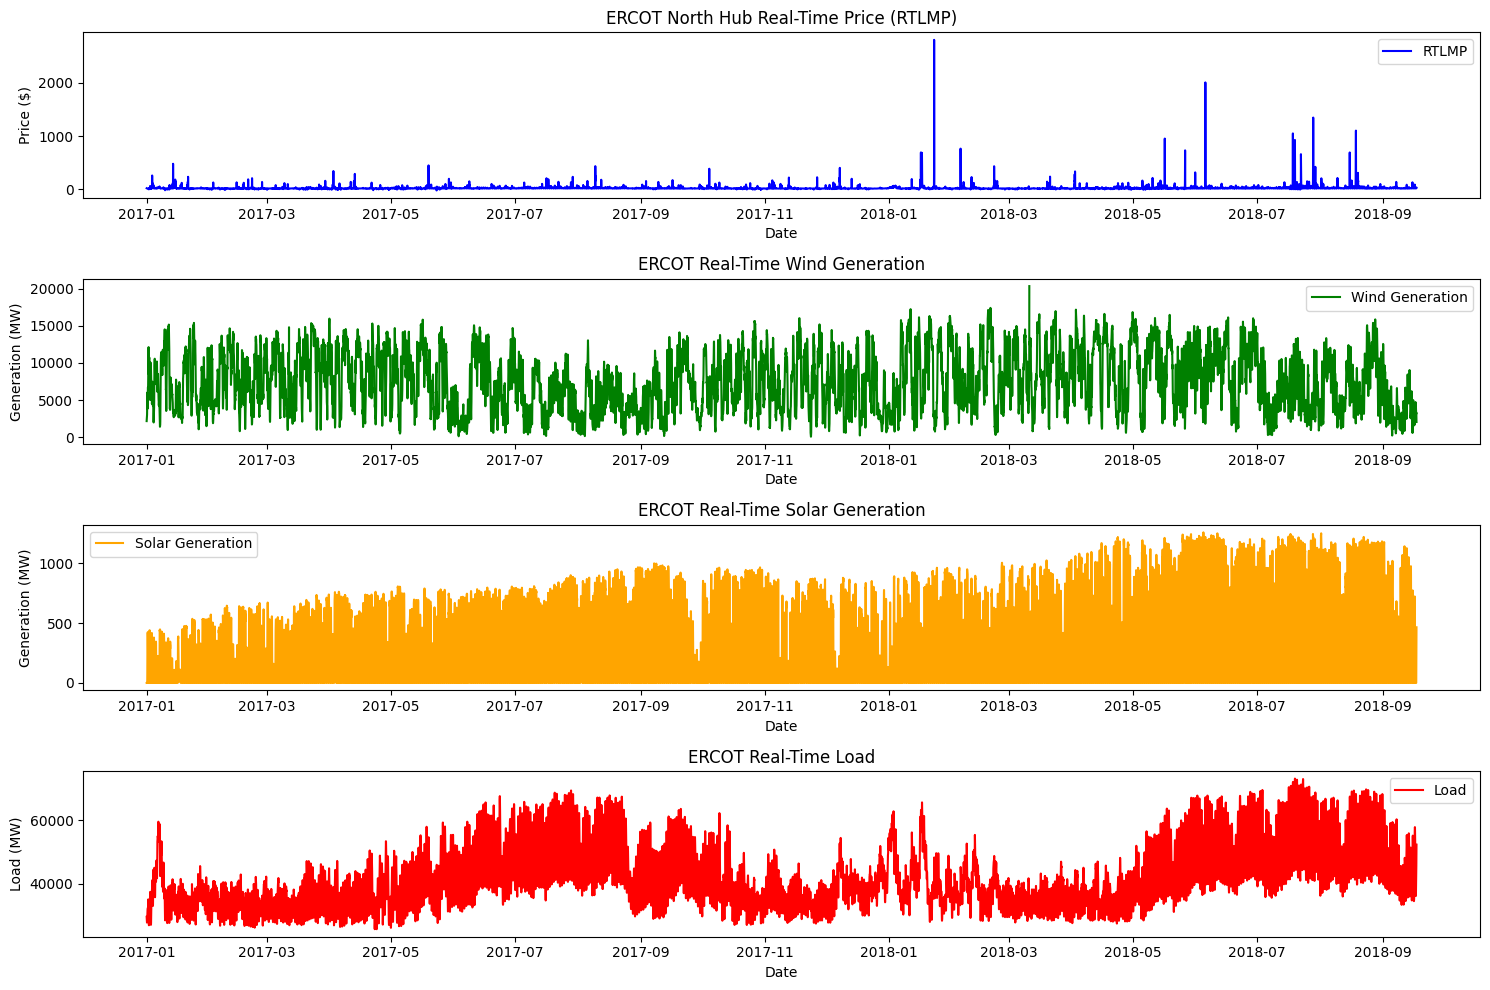

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

file_path = '/content/Summer2024/data/Assignment 3 - timeseries_data.xlsx'
data = pd.read_excel(file_path)
# Time series plots
plt.figure(figsize=(15, 10))

# Plot for RTLMP
plt.subplot(4, 1, 1)
plt.plot(data['DATETIME'], data['HB_NORTH (RTLMP)'], label='RTLMP', color='blue')
plt.title('ERCOT North Hub Real-Time Price (RTLMP)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()

# Plot for Wind Generation
plt.subplot(4, 1, 2)
plt.plot(data['DATETIME'], data['ERCOT (WIND_RTI)'], label='Wind Generation', color='green')
plt.title('ERCOT Real-Time Wind Generation')
plt.xlabel('Date')
plt.ylabel('Generation (MW)')
plt.legend()

# Plot for Solar Generation
plt.subplot(4, 1, 3)
plt.plot(data['DATETIME'], data['ERCOT (GENERATION_SOLAR_RT)'], label='Solar Generation', color='orange')
plt.title('ERCOT Real-Time Solar Generation')
plt.xlabel('Date')
plt.ylabel('Generation (MW)')
plt.legend()

# Plot for Load
plt.subplot(4, 1, 4)
plt.plot(data['DATETIME'], data['ERCOT (RTLOAD)'], label='Load', color='red')
plt.title('ERCOT Real-Time Load')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Summary statistics
summary_stats = pd.DataFrame(data[['HB_NORTH (RTLMP)','ERCOT (WIND_RTI)','ERCOT (GENERATION_SOLAR_RT)','ERCOT (RTLOAD)']].describe())
summary_stats

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD)
count,14987.000000,14982.000000,14983.000000,14987.000000
mean,25.766417,7532.436283,291.989714,42371.673703
std,46.361945,3992.884834,370.914596,9874.339631
min,-17.860000,54.440000,0.000000,25566.511248
25%,18.041250,4135.630000,0.000000,35431.636526
50%,20.057500,7281.445000,22.150000,39934.007113
75%,25.030000,10851.647500,608.635000,47873.100786
max,2809.357500,20350.400000,1257.540000,73264.662123


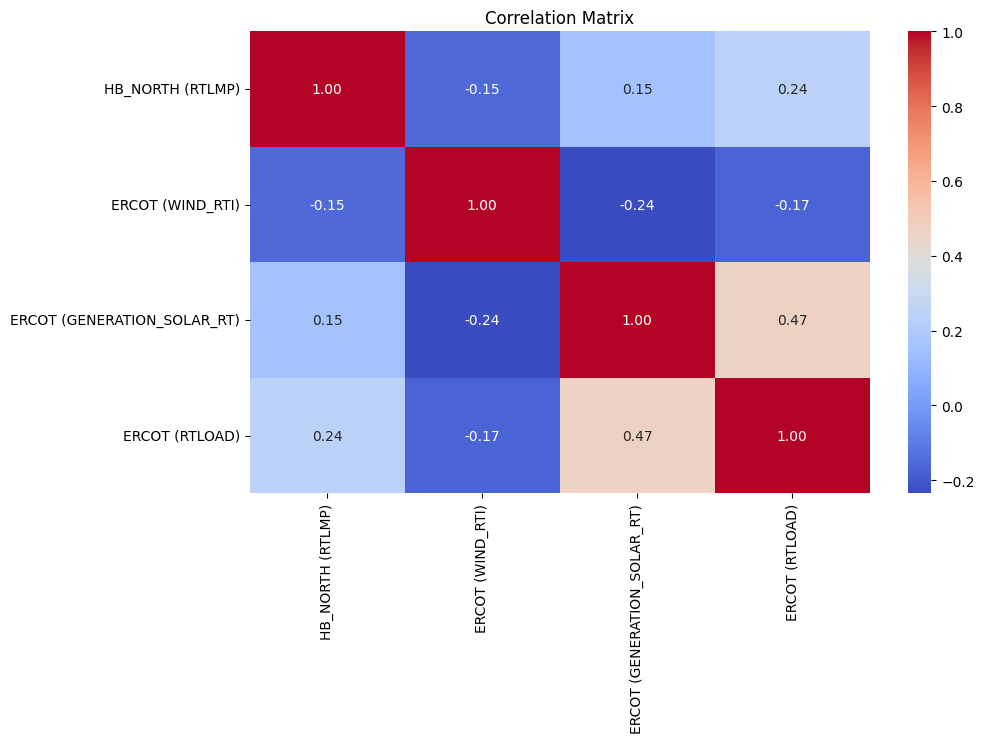

In [78]:
# Correlation matrix
corr_matrix = data[['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

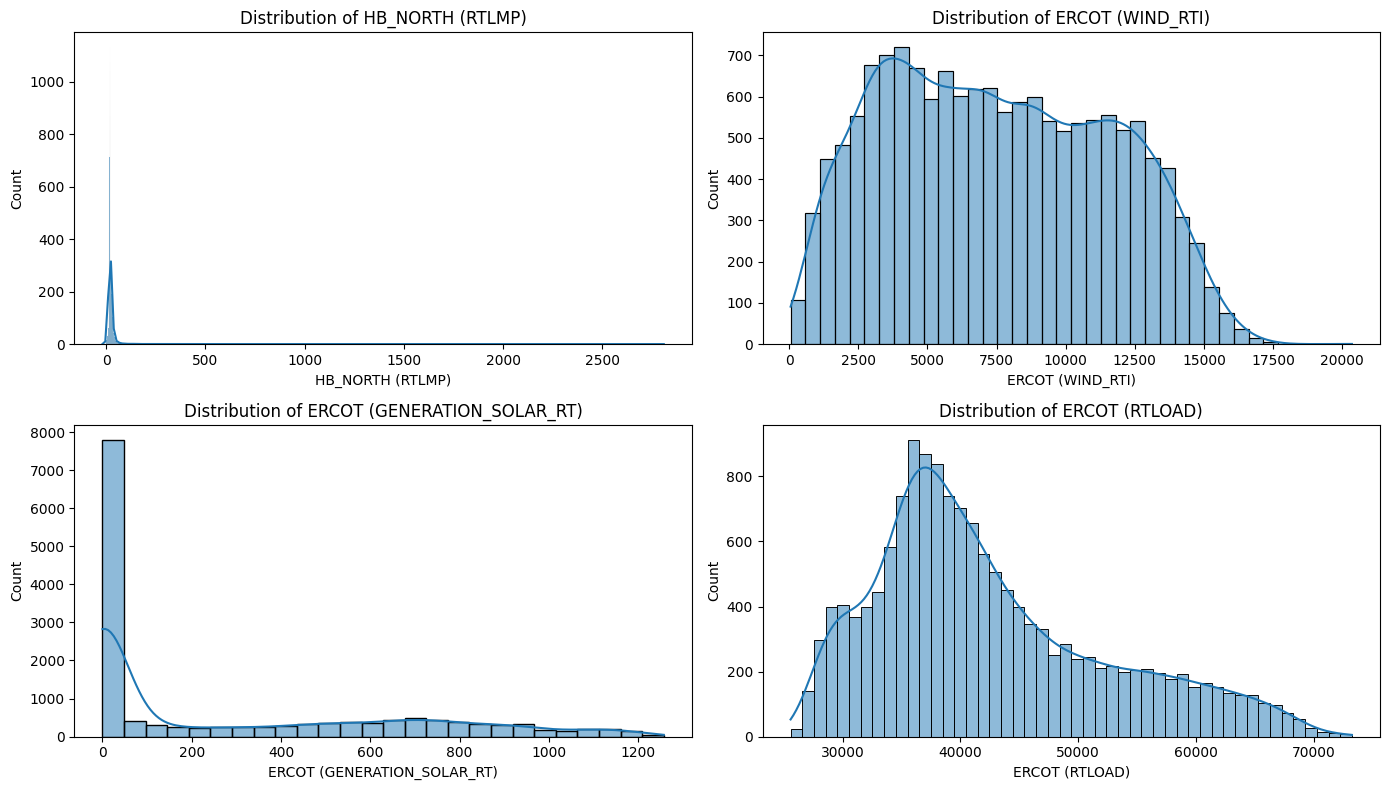

In [79]:
# Distribution plots
plt.figure(figsize=(14, 8))
for i, col in enumerate(['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'ERCOT (RTLOAD)']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [84]:
data.set_index('DATETIME', inplace=True)
# Create lagged features for the independent variables
for lag in range(1, 10):
    data[f'WIND_RTI_LAG_{lag}'] = data['ERCOT (WIND_RTI)'].shift(lag)
    data[f'SOLAR_RT_LAG_{lag}'] = data['ERCOT (GENERATION_SOLAR_RT)'].shift(lag)
    data[f'RTLOAD_LAG_{lag}'] = data['ERCOT (RTLOAD)'].shift(lag)

# Drop rows with NaN values due to lagging
data.dropna(inplace=True)

# Define features and target variable
X = data.drop(columns=['HB_NORTH (RTLMP)', 'HOURENDING', 'MARKETDAY', 'PEAKTYPE', 'MONTH', 'YEAR'])
y = data['HB_NORTH (RTLMP)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Evaluate the model
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
train_mae_lr = mean_absolute_error(y_train, y_pred_train_lr)
test_mae_lr = mean_absolute_error(y_test, y_pred_test_lr)

In [76]:
print(f"Train RMSE: {train_rmse_lr}")
print(f"Test RMSE: {test_rmse_lr}")
print(f"Train MAE: {train_mae_lr}")
print(f"Test MAE: {test_mae_lr}")

Train RMSE: 33.20643176095252
Test RMSE: 74.0161874477612
Train MAE: 8.179845754673066
Test MAE: 12.668565251608067


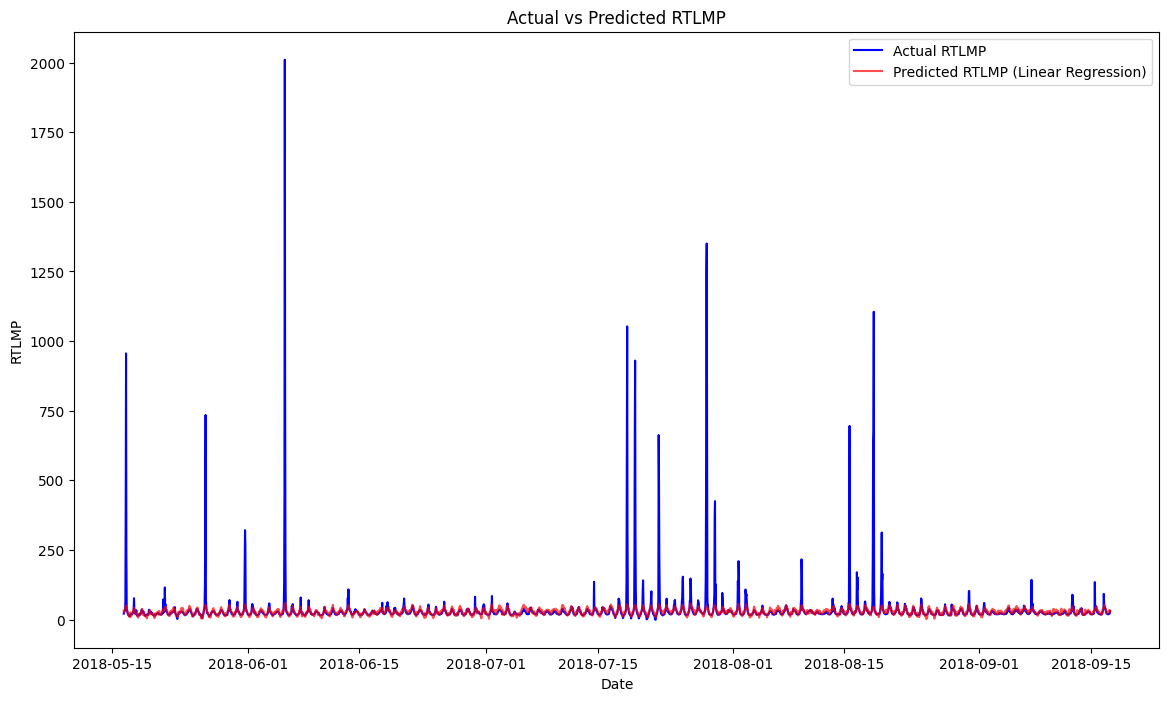

In [77]:
# Visualize the prediction vs actual values for the test set
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual RTLMP', color='blue')
plt.plot(y_test.index, y_pred_test_lr, label='Predicted RTLMP (Linear Regression)', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('RTLMP')
plt.title('Actual vs Predicted RTLMP')
plt.legend()
plt.show()

Mean Squared Error: 3634.875372547783


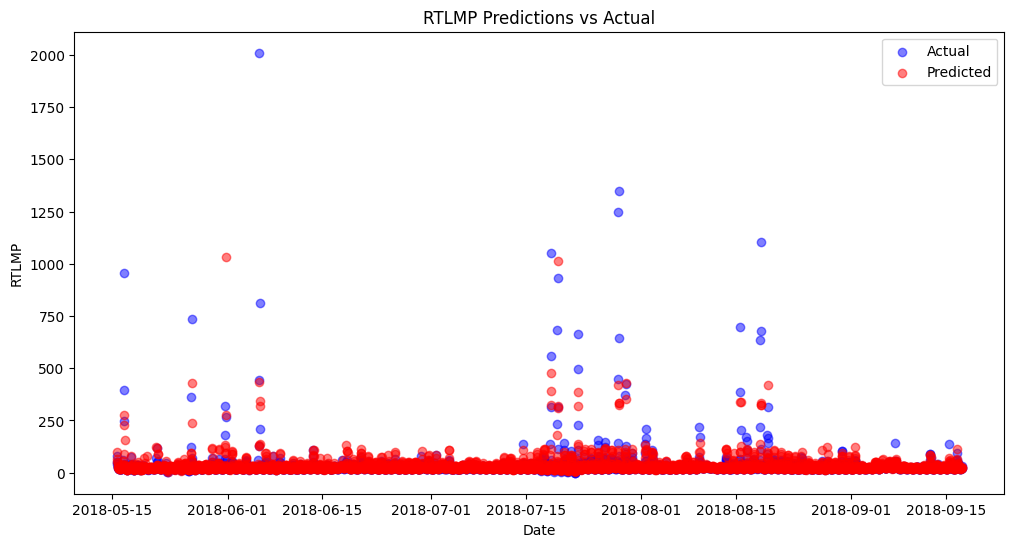

In [74]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

data['Hour'] = data['DATETIME'].dt.hour
data['DayOfWeek'] = data['DATETIME'].dt.dayofweek
data['Month'] = data['DATETIME'].dt.month

# Ensure lag is defined
lag = 1
data['RTLMP-lag'] = data['HB_NORTH (RTLMP)'].shift(lag)

# Drop rows with NaN values created by the shift
data.dropna(inplace=True)

# Features and Target
features = data[['ERCOT (RTLOAD)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)', 'RTLMP-lag', 'Hour', 'DayOfWeek', 'Month']]
target = data['HB_NORTH (RTLMP)']

# Build the model
# Using shuffle = False to avoid random split for time series data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(data.loc[y_test.index, 'DATETIME'], y_test, color='blue', label='Actual', alpha=0.5)
plt.scatter(data.loc[y_test.index, 'DATETIME'], predictions, color='red', label='Predicted', alpha=0.5)
plt.legend()
plt.title('RTLMP Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('RTLMP')
plt.show()

Since the data is non-linear, I use Random Forest to make the forecast. To improve the prediction, I introduce one lag of RTLMP as a variable for the forecast. From the plot, we can see that the red points cover most of the normal blue points. Additionally, the red points also cover some of the blue points more effectively than the previous Linear Regression Model.


# Assignment 4


## 1. Understanding the Products

#### Product 1: Power Futures - ERN
ERCOT North 345KV Real-Time Peak Fixed Price Future is a futures contract for the delivery of electric power at a specified price. It covers the peak hours (HE 0700-2200) for ERCOT North hub and is settled financially.

#### Product 2: Natural Gas Futures - H
Henry LD1 Fixed Price Future is a futures contract for the delivery of natural gas at the Henry Hub, the primary trading point for natural gas in the U.S. It is settled financially.

#### Product 3: Heat Rate Futures - XPR
ERCOT North 345KV Physical HR Peak HE 0700-2200 Future is a futures contract that involves the heat rate, which is the ratio of the price of power to the price of natural gas, typically used as a measure of the efficiency of power plants.

## 2. Hedging Method

#### Assumptions
1. All futures contracts are settled financially, meaning no physical delivery of the underlying asset is required.
2. **Contract Sizes**:
   - **Power Futures (ERN)**: Each contract represents 1 MW of power (assumed for simplicity).
   - **Natural Gas Futures (H)**: Each contract represents 10,000 MMBtu of natural gas (typical contract size for Henry Hub futures).
   Reference:https://www.cmegroup.com/markets/energy/natural-gas/natural-gas.html
   - **Heat Rate Futures (XPR)**: Each contract represents the heat rate directly (assumed for simplicity).
3. **Rebalancing Frequency**:
   - The position in natural gas futures is rebalanced weekly based on the new settlement prices. The heat rate futures position remains static throughout the hedging period.

#### Hedging Strategy

1. **Data Preparation**: Clean and organize the data for analysis.
2. **Initial Position Setup**: Calculate the initial positions for natural gas and heat rate futures required to hedge the exposure.
   - **Hedge Ratio**:
     - **Natural Gas Hedge**: The hedge ratio can be calculated as the ratio of the power price to the natural gas price.
     - **Heat Rate Hedge**: The heat rate futures directly represent the efficiency and can be used without additional calculations.
3. **Weekly Rebalance Implementation**: Every week, rebalance the position in natural gas futures to reflect changes in market prices. Heat rate futures remain static.
4. **Efficiency Measurement**: Track the hedging performance by comparing the hedged portfolio's value against the unhedged physical power position. Analyze the efficiency by comparing the hedged vs. unhedged positions.

## 3. Initial Calculations Summary

- **Initial Date**: November 28, 2016
- **Power Price (ERN)**: \$27.77/MW
- **Natural Gas Price (H)**: \$3.232/MMBtu
- **Heat Rate (XPR)**: 8.592203 (ratio)

#### Hedge Ratio
- **Hedge Ratio for Gas**: 8.592203

#### Initial Contracts
- **Natural Gas Contracts**: 0.000859 (This value suggests that per MW of power, a tiny fraction of a gas contract is required. This number needs to be scaled appropriately for practical purposes.)


In [ ]:
file_path = '/content/Summer2024/data/Assignment 4 - dataset.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

data_sheet = data['Sheet1']
data_sheet.columns = data_sheet.iloc[2]  # Set the third row as header
data_sheet = data_sheet.drop([0, 1, 2])  # Drop the first three rows
data_sheet.columns = ['Date', 'ERN_Settlement_Price', 'H_Settlement_Price', 'XPR_Settlement_Price']
data_sheet['Date'] = pd.to_datetime(data_sheet['Date'])

# Convert settlement prices to numeric
data_sheet['ERN_Settlement_Price'] = pd.to_numeric(data_sheet['ERN_Settlement_Price'], errors='coerce')
data_sheet['H_Settlement_Price'] = pd.to_numeric(data_sheet['H_Settlement_Price'], errors='coerce')
data_sheet['XPR_Settlement_Price'] = pd.to_numeric(data_sheet['XPR_Settlement_Price'], errors='coerce')

data_sheet = data_sheet.dropna()
initial_date = data_sheet.iloc[0]

initial_power_price = initial_date['ERN_Settlement_Price']
initial_gas_price = initial_date['H_Settlement_Price']
initial_heat_rate = initial_date['XPR_Settlement_Price']

# Contract sizes
power_contract_size = 1  # MW
gas_contract_size = 10000  # MMBtu

# Hedge ratio calculation
hedge_ratio_gas = initial_power_price / initial_gas_price
# Initial number of contracts
initial_gas_contracts = hedge_ratio_gas / gas_contract_size
# Resampling the data to weekly frequency
weekly_data = data_sheet.resample('W-Mon', on='Date').first().reset_index()

initial_positions = {
    'Date': weekly_data['Date'],
    'ERN_Settlement_Price': weekly_data['ERN_Settlement_Price'],
    'H_Settlement_Price': weekly_data['H_Settlement_Price'],
    'XPR_Settlement_Price': weekly_data['XPR_Settlement_Price']
}


positions_df = pd.DataFrame(initial_positions)

# Initial number of gas contracts based on the initial hedge ratio
initial_gas_contracts = hedge_ratio_gas / gas_contract_size
# Weekly rebalance calculation
positions_df['Gas_Contracts'] = initial_gas_contracts
positions_df['Hedge_Value'] = positions_df['Gas_Contracts'] * positions_df['H_Settlement_Price'] * gas_contract_size
# Calculate the efficiency of the hedge
positions_df['Unhedged_Position'] = positions_df['ERN_Settlement_Price'] * power_contract_size
positions_df['Hedged_Position'] = positions_df['Unhedged_Position'] - positions_df['Hedge_Value']
positions_df['Hedging_Efficiency'] = (positions_df['Unhedged_Position'] - positions_df['Hedged_Position']) / positions_df['Unhedged_Position']


In [ ]:
positions_df

,Date,ERN_Settlement_Price,H_Settlement_Price,XPR_Settlement_Price,Gas_Contracts,Hedge_Value,Unhedged_Position,Hedged_Position,Hedging_Efficiency
0,2016-02-01,24.62,2.713,9.074825,0.000859,23.310647,24.62,1.309353,0.946817
1,2016-02-08,24.16,2.656,9.096386,0.000859,22.820891,24.16,1.339109,0.944573
2,2016-02-15,24.55,2.684,9.146796,0.000859,23.061473,24.55,1.488527,0.939368
3,2016-02-22,23.52,2.568,9.158879,0.000859,22.064777,23.52,1.455223,0.938128
4,2016-02-29,22.54,2.436,9.252874,0.000859,20.930606,22.54,1.609394,0.928598
5,2016-03-07,23.63,2.521,9.373265,0.000859,21.660944,23.63,1.969056,0.916671
6,2016-03-14,23.80,2.539,9.373769,0.000859,21.815603,23.80,1.984397,0.916622
7,2016-03-21,25.13,2.681,9.373368,0.000859,23.035696,25.13,2.094304,0.916661
8,2016-03-28,25.41,2.717,9.352227,0.000859,23.345015,25.41,2.064985,0.918733
9,2016-04-04,26.11,2.810,9.291815,0.000859,24.144090,26.11,1.965910,0.924707
